# Import Libraries 

In [1]:
import pandas as pd 
import numpy as np
import missingno as msno
from ydata_profiling import ProfileReport
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import scipy.cluster.hierarchy as shc
from kneed import KneeLocator
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, train_test_split
from hyperopt import fmin, space_eval, tpe, hp
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
from scipy.sparse import csr_matrix
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
import math
import squarify
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Define Functions

In [2]:
def group_and_size(list1, list2):
    groups = {}
    for i in range(len(list1)):
        if list1[i] not in groups:
            groups[list1[i]] = []
        groups[list1[i]].append(list2[i])
    
    result = {}
    total = len(list2)
    for key in groups.keys():
        group_size = len(groups[key])
        group_percentage = group_size
        result[key] = group_percentage
        
    result = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))
    
    return pd.DataFrame(list(result.items()), columns=["Cluster", "Size"])

# Read DataFrame

In [3]:
with open("fulldata.csv", "rb") as f:
    result = chardet.detect(f.read())

df = pd.read_csv("fulldata.csv", encoding=result["encoding"], header=0, delimiter=';')
df.to_csv('new_file.csv', index=False, encoding='utf-8')

df = pd.read_csv('new_file.csv', header=0, delimiter=',', decimal=',')
df

,Étiquettesdelignes,Formulebible,Plant,couche1,couche2,couche3,AD,Bimodal,EVA045,EVA05,...,PEEL,PP,PPC,PPH,PPR,PPsoft,Reg,VLLD,EVA1,EVA2
0,100098,100098,Kufstein,10.0,70.0,20.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.00
1,101087,101087,Kufstein,20.0,60.0,20.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.00
2,101088,101088,Kufstein,20.0,70.0,10.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.00
3,101189,101189,Kufstein,30.0,40.0,30.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.00
4,101581,101581,Kufstein,20.0,60.0,20.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,ZF0750H1AC,ZF0750H1AC,Firminy/montfaucon,20.0,60.0,20.0,5.60,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0,0.0,0.00
558,ZF0752A2,ZF0752A2,Firminy/montfaucon,20.0,60.0,20.0,2.80,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.00
559,ZF0770A1,ZF0770A1,Firminy/montfaucon,8.0,72.0,20.0,1.08,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,7.92
560,ZF0770A1AA,ZF0770A1AA,Firminy/montfaucon,8.0,72.0,20.0,3.12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,7.92


# EDA - Exploratory Data Analysis

## Full Profiling

In [4]:
# profile = ProfileReport(df, title="Profiling Report", html = {'style':{'primary_color': "#000000"}})
# profile.to_file("output.html")

## See if any of the columns are the same

In [5]:
BOLD = '\033[1m'
RESET = '\033[0m'

# Loop through each column pair and print if they are the same
for i in range(len(df.columns)):
    for j in range(i + 1, len(df.columns)):
        if (df.iloc[:,i] == df.iloc[:,j]).all():
            print(f"Columns {BOLD}{df.columns[i]}{RESET} and {BOLD}{df.columns[j]}{RESET} are the same.")

Columns Étiquettesdelignes and Formulebible are the same.


## See if any of the columns are zero for all observation

In [6]:
# set the threshold for the percentage of zero values
threshold = 0.75

# create an empty list to store tuples of column names and zero percentages
zero_cols = []

# loop through all columns in the DataFrame
for col in df.columns:
    # calculate the percentage of zero values in the column
    zero_percentage = (df[col] == 0).sum() / len(df)
    # check if the zero percentage exceeds the threshold
    if zero_percentage > threshold:
        zero_cols.append((col, zero_percentage))

# sort the list of tuples based on the zero percentages in descending order
zero_cols.sort(key=lambda x: x[1], reverse=True)

# print the total number of columns that meet the threshold
print("======================================================================================================")
print(f"\n{len(zero_cols)} columns out of {len(df.columns)-3} have a zero percentage above {threshold:.0%}.")
print("======================================================================================================")
# print the messages for each column
print(f"'Percentage of zero values for all observations")
for col, zero_percentage in zero_cols:
    print(f"'{col} {BOLD}{zero_percentage:.2%}{RESET}")


43 columns out of 48 have a zero percentage above 75%.
'Percentage of zero values for all observations
'EVA094 99.82%
'HV_PE 99.82%
'mPE 99.82%
'EVA075 99.64%
'IO 99.64%
'LLDgreen 99.64%
'mLLD_C4terpolymer 99.64%
'PPH 99.64%
'MAA 99.47%
'PPC 99.47%
'VLLD 99.47%
'PEEL 99.29%
'Bimodal 99.11%
'EVA055 98.93%
'MDPE 98.93%
'PB 97.69%
'PP 97.69%
'EVA17 97.15%
'mLLD 97.15%
'PPsoft 97.15%
'EVA135 96.80%
'PPR 96.80%
'PE 96.26%
'EVA05 95.55%
'EVA28 94.84%
'EVA14 94.48%
'LLD_C6 94.48%
'mVLLD_C8 94.13%
'EVA045 93.95%
'EVA18 89.32%
'MD 88.79%
'Reg 88.26%
'EVA1 88.08%
'mLLD_C4 87.90%
'mLLD_C6 86.12%
'LLD_C8 85.94%
'mLLD_C8 85.77%
'HD 85.59%
'mPE_C8 83.10%
'LLD 82.92%
'EVA2 77.76%
'LLD_C4 77.05%
'AD 75.27%


## Check for missing values

<AxesSubplot: >

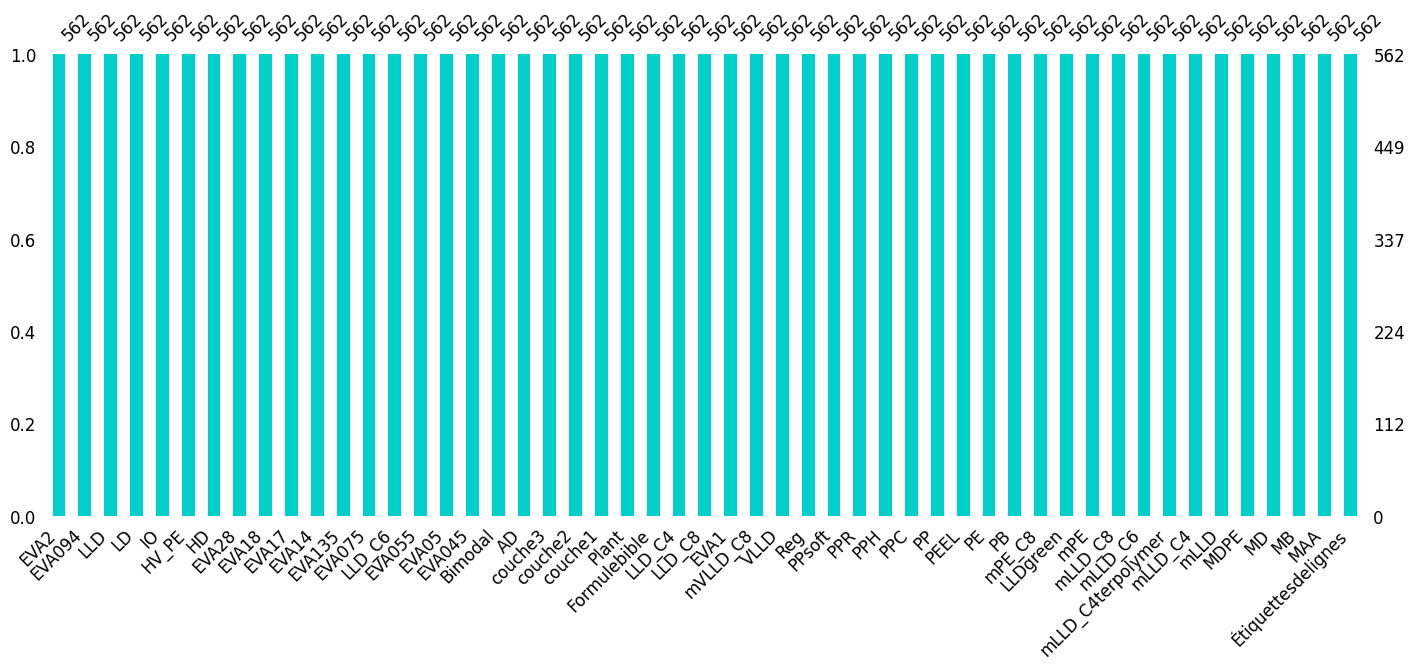

In [7]:
# Bar plot of missing values and percentage
msno.bar(df, labels=True, figsize=(17,6), fontsize=12, sort="descending", color="#00cfcc")

## Desciptive Stadistics

In [8]:
pd.set_option('display.max_columns', 60)
df.describe()

,couche1,couche2,couche3,AD,Bimodal,EVA045,EVA05,EVA055,EVA075,EVA094,EVA135,EVA14,EVA17,EVA18,EVA28,HD,HV_PE,IO,LD,LLD,LLD_C4,LLD_C6,LLD_C8,LLDgreen,MAA,MB,MD,MDPE,mLLD,mLLD_C4,mLLD_C4terpolymer,mLLD_C6,mLLD_C8,mPE,mPE_C8,mVLLD_C8,PB,PE,PEEL,PP,PPC,PPH,PPR,PPsoft,Reg,VLLD,EVA1,EVA2
count,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000
mean,21.100770,55.692540,23.206690,0.700062,0.284630,1.011558,0.559476,0.444448,0.195374,0.034182,1.678915,3.117438,1.358648,5.838068,0.995867,2.964387,0.007228,0.043238,24.656013,5.783212,5.475387,2.656996,6.542568,0.220979,0.299355,3.621186,2.080080,0.241528,0.988345,5.544155,0.133274,3.975165,4.909716,0.049822,5.822544,0.821727,0.043710,2.278616,0.140483,1.677829,0.249973,0.033985,0.429083,0.175445,1.758723,0.156584,2.245038,11.993068
std,5.023997,11.344263,10.658544,1.530942,3.027171,5.527476,3.208214,4.342641,3.286278,0.810339,9.367843,12.931114,8.577873,17.346604,4.388971,8.794297,0.171355,0.804000,28.025371,16.596795,13.548676,12.739923,18.840754,3.700986,4.090061,3.700751,8.082022,2.341304,6.053290,16.697157,2.241849,11.530929,13.536931,1.181109,13.320515,3.500079,0.309552,11.580961,1.813730,12.397788,3.665536,0.654233,2.898012,1.144125,7.618076,2.209290,8.342763,23.106649
min,7.000000,9.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,50.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.554274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,20.000000,60.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,24.833111,60.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.584625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,40.000000,80.000000,82.000000,8.700000,36.879712,70.000000,29.500000,52.000000,60.000000,19.210339,59.100000,65.800000,60.000000,70.000000,36.000000,66.243542,4.062230,18.000000,99.700000,100.000000,83.800000,75.034000,84.600000,62.250000,56.397522,18.935484,98.540000,25.794621,53.600000,94.750000,40.950000,100.000000,65.976345,28.000000,50.000000,23.249189,4.445584,64.357000,29.472716,100.000000,72.560000,14.952276,41.494445,15.800000,54.548080,40.000000,70.000000,70.000000


## Product per Plant

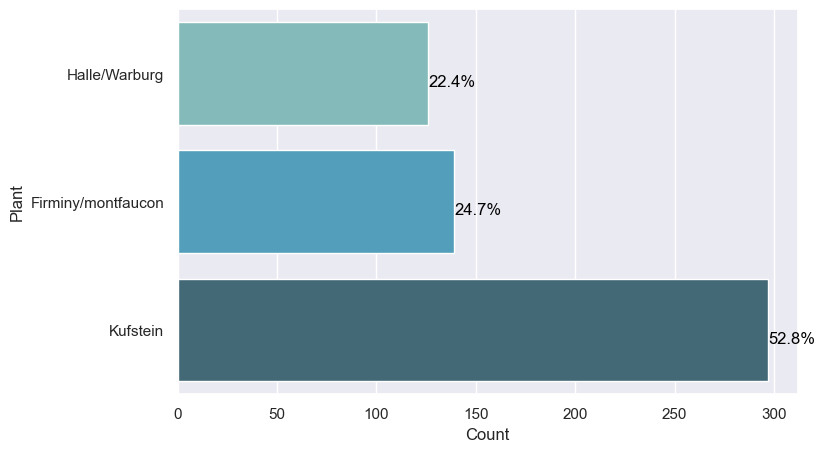

In [9]:
sns.set(rc={'figure.figsize':(8,5)})
data = df['Plant'].value_counts().sort_values().reset_index()
data.columns = ['Plant', 'Count']
ax = sns.barplot(y='Plant', x='Count', data=data, palette='GnBu_d')

# add percentage labels to each bar
total = sum(data['Count'])
for i, v in enumerate(data['Count']):
    percent = "{:.1f}%".format((v/total)*100)
    ax.text(v + 0.2, i + 0.1, percent, color='black', fontweight='normal')

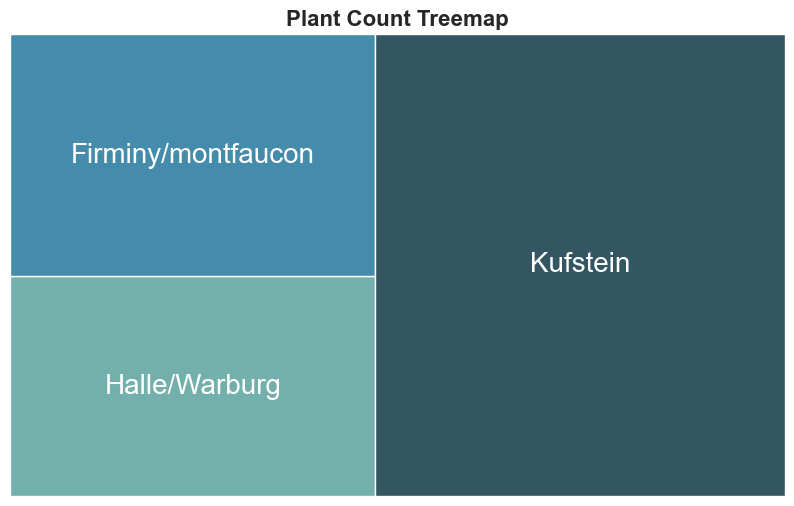

In [10]:
# create dataframe with value counts
data = df['Plant'].value_counts().sort_values().reset_index()
data.columns = ['Plant', 'Count']

# create treemap
plt.figure(figsize=(10, 6))
squarify.plot(sizes=data['Count'], label=data['Plant'], alpha=1, color=["#73AFAB","#458CAC","#345562"], text_kwargs={'color':'white', 'fontsize':20})

# add labels and formatting
plt.axis('off')
plt.title('Plant Count Treemap', fontsize=16, fontweight='bold')
plt.show()

# Define parameters

In [11]:
X = df.iloc[:,3:52]
Y = df['Formulebible']

# Define random state for reproducibility
random_seed = 1234

<AxesSubplot: >

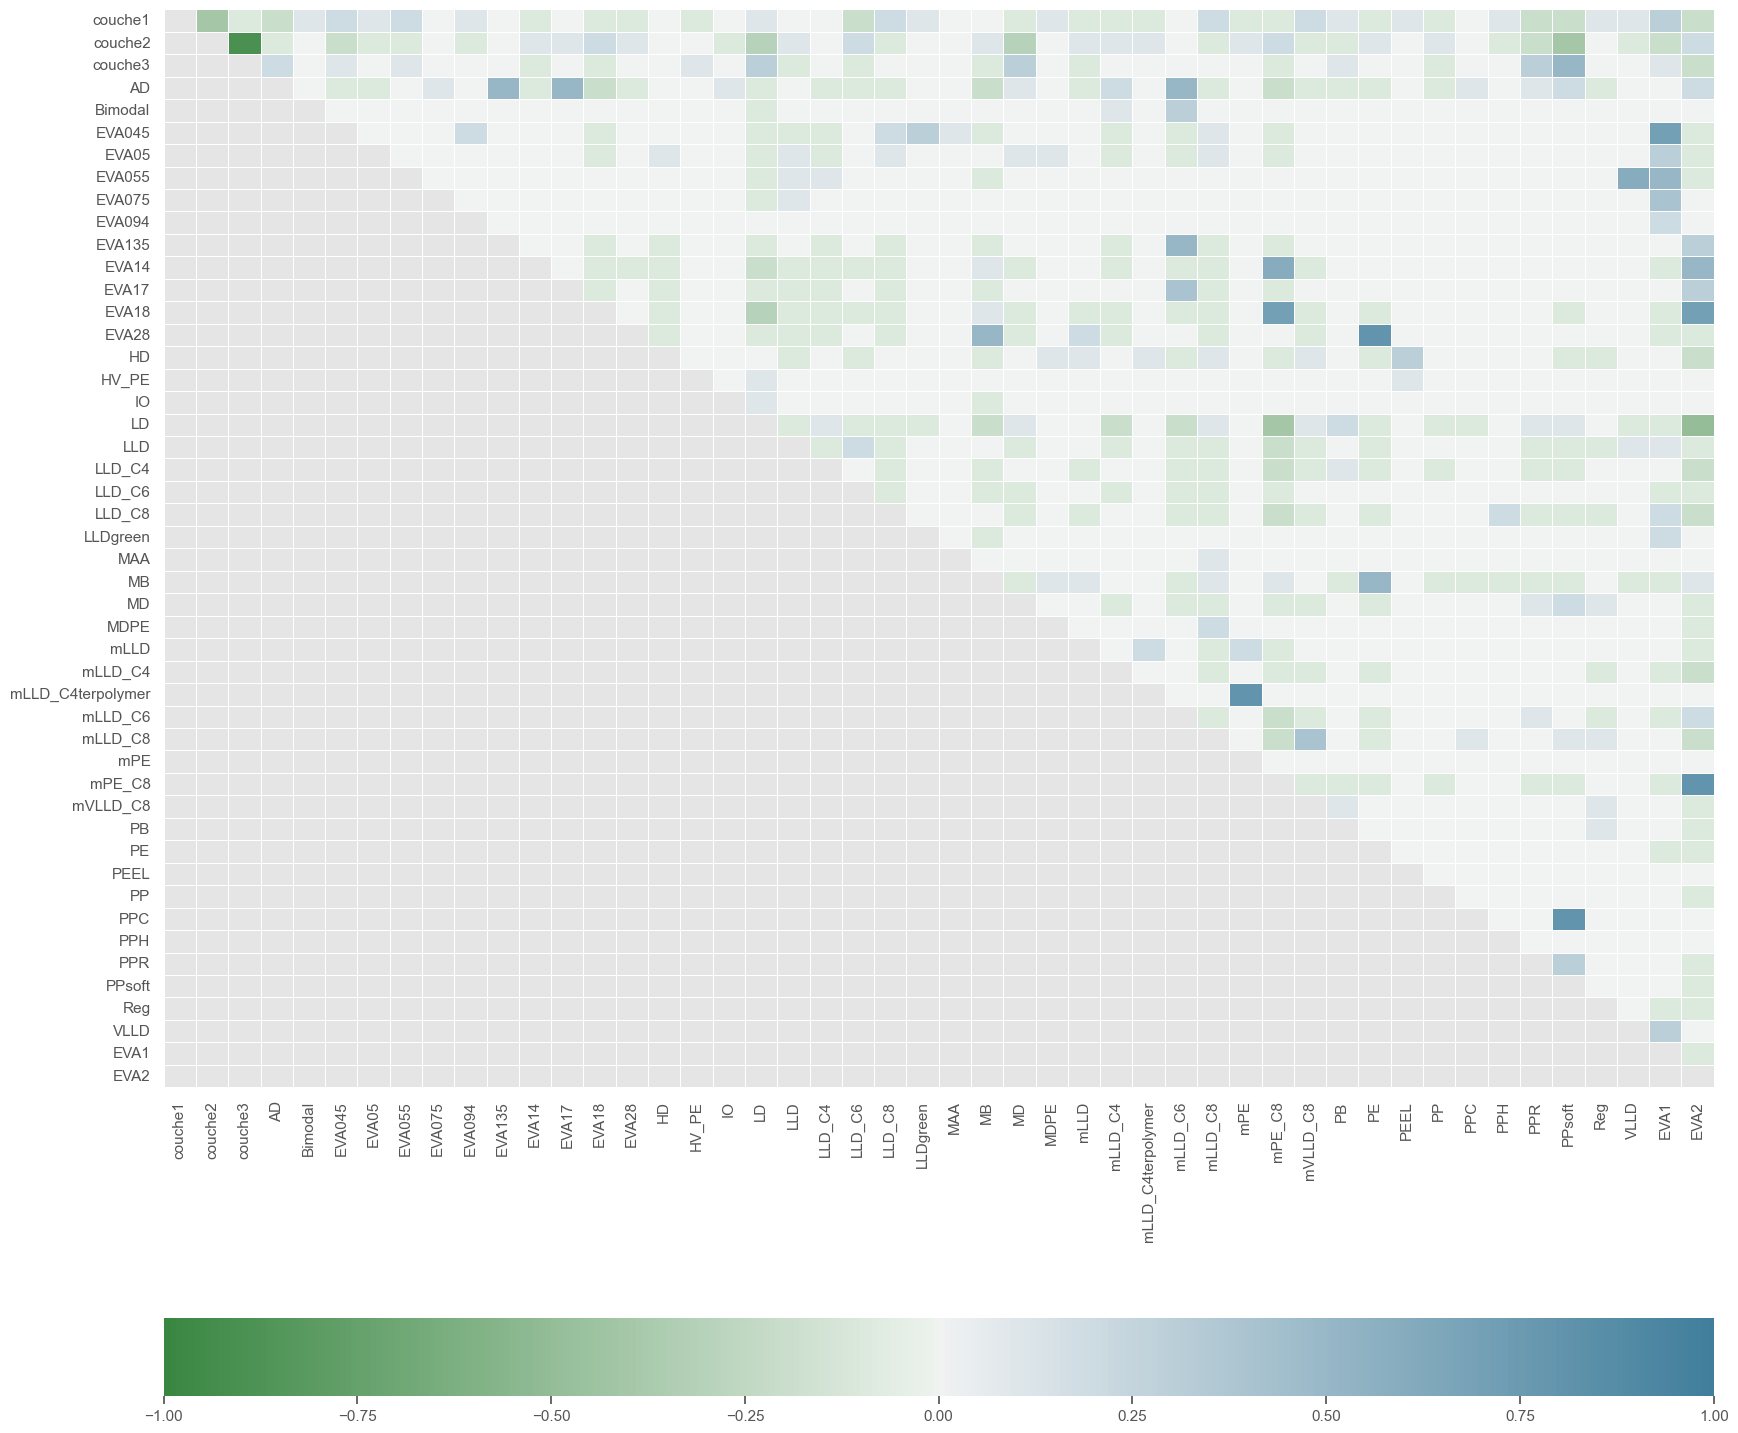

In [12]:
plt.style.use("ggplot")
f, ax = plt.subplots(figsize=(20, 20))
cv= X.corr().round(2)
matrix = np.tril(np.ones_like(cv))
cmap = sns.diverging_palette(130, 230, as_cmap=True)
sns.heatmap(X.corr().round(1),vmin=-1,vmax=1,annot=False,linewidth=.7, mask=matrix, cmap=cmap, cbar_kws= {'orientation': 'horizontal'})

# Feature Importance

## Decision Tree

In [13]:
# # Create a DecisionTreeClassifier object
# tree = DecisionTreeClassifier()

# # Train the decision tree model
# tree.fit(X, Y)

# # Extract feature importance
# feature_importance = tree.feature_importances_

# # Create a DataFrame with feature names and their importance values as percentages
# features_df = pd.DataFrame({'Feature': X.columns, 'Importance': (feature_importance*100).round(2)})

# # Sort the DataFrame by feature importance values in descending order
# features_df = features_df.sort_values(by='Importance', ascending=False)

# # Print the sorted DataFrame
# features_df

In [14]:
# combined_df = pd.DataFrame({'Feature': X.columns, 'Importance': (feature_importance*100).round(2)})
# for col, zero_percentage in zero_cols:
#     combined_df.loc[combined_df['Feature'] == col, 'Importance'] = (zero_percentage*100).round(2)

# # Sort the DataFrame by feature importance values in descending order
# combined_df = combined_df.sort_values(by='Importance', ascending=False)

# # Print the sorted DataFrame
# print(combined_df)

## Using Poc Dataset to confirm feature importance

In [15]:
df_poc = pd.read_excel("DetailedData - PoC.xls", header = 0)
df_poc

prefixes = ['EVA', 'HD', 'LD', 'LLD', 'MB', 'MDPE', 'mLLD', 'mPEC', 'mVLLD_C', 'PB', 'PP', 'Reg']
prefix_dict = {prefix: [col for col in df_poc.columns if col.startswith(prefix)] for prefix in prefixes}

for prefix, cols in prefix_dict.items():
    df_poc[f'{prefix}_sum'] = df_poc[cols].sum(axis=1)
    
    
X_poc = df_poc.iloc[:,47:59]
Y_poc = df_poc['GroupJanTorsten']

df_poc

,tiquettesdelignes,EVA51,HD1,LD1,LLD1,LLDC41,LLD_C81,MB1,MDPE1,mLLD1,mLLD_C41,mPEC81,mVLLD_C81,PP1,Reg1,EVA142,EVA52,HD2,LD2,LLD2,LLDC42,LLD_C82,MB2,MDPE2,mLLD2,mLLD_C42,mLLD_C4terpolymer2,mLLD_C62,mPE2,mPEC82,PP2,Reg2,EVA53,HD3,LD3,LLD3,LLDC43,LLD_C83,MB3,MDPE3,mLLD3,mLLD_C43,mLLD_C63,mPEC83,PB3,PP3,GroupJanTorsten,EVA_sum,HD_sum,LD_sum,LLD_sum,MB_sum,MDPE_sum,mLLD_sum,mPEC_sum,mVLLD_C_sum,PB_sum,PP_sum,Reg_sum
0,114233,0.00,0.0,0.000,0.00,0.000,0.0,0.040,0.00,0.0,0.0,0.96,0,0.0,0,0.9,0.000,0.000,0.000,0.000,0.000,0.0,0.100,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.040,0.00,0.0,0.0,0.0,0.96,0.0,0.0,BF,0.900,0.000,0.000,0.000,0.180,0.000,0.0,1.92,0,0.0,0.0,0.0
1,112701,0.68,0.0,0.000,0.30,0.000,0.0,0.020,0.00,0.0,0.0,0.00,0,0.0,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.000,0.000,0.0,0.000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,BHD,0.680,1.000,0.000,0.300,0.020,1.000,0.0,0.00,0,0.0,0.0,0.0
2,103597,0.68,0.0,0.000,0.30,0.000,0.0,0.020,0.00,0.0,0.0,0.00,0,0.0,0,0.0,0.014,0.025,0.000,0.006,0.000,0.0,0.000,0.955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.000,0.000,0.0,0.000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,BHD,0.694,1.025,0.000,0.306,0.020,0.955,0.0,0.00,0,0.0,0.0,0.0
3,109938,0.00,0.0,0.150,0.00,0.828,0.0,0.022,0.00,0.0,0.0,0.00,0,0.0,0,0.0,0.000,0.000,0.150,0.000,0.838,0.0,0.012,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150,0.000,0.828,0.0,0.022,0.00,0.0,0.0,0.0,0.00,0.0,0.0,BK,0.000,0.000,0.450,2.494,0.056,0.000,0.0,0.00,0,0.0,0.0,0.0
4,110885,0.00,0.0,0.150,0.00,0.832,0.0,0.018,0.00,0.0,0.0,0.00,0,0.0,0,0.0,0.000,0.000,0.150,0.000,0.842,0.0,0.008,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150,0.000,0.832,0.0,0.018,0.00,0.0,0.0,0.0,0.00,0.0,0.0,BK,0.000,0.000,0.450,2.506,0.044,0.000,0.0,0.00,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,108698,0.00,0.0,1.000,0.00,0.000,0.0,0.000,0.00,0.0,0.0,0.00,0,0.0,0,0.0,0.000,0.000,1.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150,0.000,0.830,0.0,0.020,0.00,0.0,0.0,0.0,0.00,0.0,0.0,TPS,0.000,0.000,2.150,0.830,0.020,0.000,0.0,0.00,0,0.0,0.0,0.0
148,117658,0.00,0.0,0.673,0.15,0.000,0.0,0.027,0.15,0.0,0.0,0.00,0,0.0,0,0.0,0.000,0.000,0.730,0.000,0.000,0.0,0.070,0.200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.673,0.150,0.000,0.0,0.027,0.15,0.0,0.0,0.0,0.00,0.0,0.0,Tube,0.000,0.000,2.076,0.300,0.124,0.500,0.0,0.00,0,0.0,0.0,0.0
149,116743,0.00,0.0,0.605,0.00,0.250,0.0,0.045,0.10,0.0,0.0,0.00,0,0.0,0,0.0,0.000,0.000,0.583,0.000,0.250,0.0,0.067,0.100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605,0.000,0.250,0.0,0.045,0.10,0.0,0.0,0.0,0.00,0.0,0.0,Tube,0.000,0.000,1.793,0.750,0.157,0.300,0.0,0.00,0,0.0,0.0,0.0
150,109756,0.00,0.0,0.985,0.00,0.000,0.0,0.015,0.00,0.0,0.0,0.00,0,0.0,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.935,0.000,0.0,0.065,0.00,0.0,0.0,0.0,0.00,0.0,0.0,UKM,0.000,0.000,0.985,0.935,0.080,0.000,1.0,0.00,0,0.0,0.0,0.0


In [16]:
# Create a RandomForestClassifier object with n_estimators=100 (you can change this value as per your requirements)
rf = RandomForestClassifier(n_estimators=100)

# Train the Random Forest model
rf.fit(X_poc, Y_poc)

# Extract feature importance
feature_importance = rf.feature_importances_

# Create a DataFrame with feature names and their importance values as percentages
features_df_poc = pd.DataFrame({'Feature': X_poc.columns, 'Importance': (feature_importance*100).round(2)})

# Sort the DataFrame by feature importance values in descending order
features_df_poc = features_df_poc.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
features_df_poc

,Feature,Importance
3,LLD_sum,22.58
2,LD_sum,20.25
4,MB_sum,18.29
5,MDPE_sum,9.39
1,HD_sum,7.01
6,mLLD_sum,6.82
11,Reg_sum,5.20
9,PB_sum,3.35
7,mPEC_sum,2.96
10,PP_sum,2.26


In [17]:
columns = X.columns

similar_variables = {}

for column in columns:
    prefix = column[:2]
    if prefix in similar_variables:
        similar_variables[prefix] += 1
    else:
        similar_variables[prefix] = 1

df_variable = pd.DataFrame({'prefix': list(similar_variables.keys()), 'count': list(similar_variables.values())})
total_count = df_variable['count'].sum()
df_variable.loc[len(df)] = ['Total', total_count]
print(df_variable)

    prefix  count
0       co      3
1       AD      1
2       Bi      1
3       EV     12
4       HD      1
5       HV      1
6       IO      1
7       LD      1
8       LL      5
9       MA      1
10      MB      1
11      MD      2
12      mL      5
13      mP      2
14      mV      1
15      PB      1
16      PE      2
17      PP      5
18      Re      1
19      VL      1
562  Total     48


# Redefine parametres 

## Drop Variables that have more than 95% zero values

In [18]:
zero_percent = (df == 0).sum() / len(df)

# Create a list of column names where the percentage of zeros is greater than 90%
drop_cols = list(zero_percent[zero_percent > 0.95].index)

# Drop the columns from the DataFrame
df.drop(drop_cols, axis=1, inplace=True)
df

,Étiquettesdelignes,Formulebible,Plant,couche1,couche2,couche3,AD,EVA045,EVA14,EVA18,EVA28,HD,LD,LLD,LLD_C4,LLD_C6,LLD_C8,MB,MD,mLLD_C4,mLLD_C6,mLLD_C8,mPE_C8,mVLLD_C8,Reg,EVA1,EVA2
0,100098,100098,Kufstein,10.0,70.0,20.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,75.948,11.12,12.932,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,101087,101087,Kufstein,20.0,60.0,20.0,0.00,0.0,0.0,0.0,0.0,0.0,58.60,40.000,0.00,0.000,0.0,1.40,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,101088,101088,Kufstein,20.0,70.0,10.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,75.948,11.12,12.932,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,101189,101189,Kufstein,30.0,40.0,30.0,0.00,0.0,0.0,0.0,0.0,0.0,79.04,0.000,19.76,0.000,0.0,1.20,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,101581,101581,Kufstein,20.0,60.0,20.0,0.00,0.0,0.0,0.0,0.0,0.0,79.40,20.000,0.00,0.000,0.0,0.60,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,ZF0750H1AC,ZF0750H1AC,Firminy/montfaucon,20.0,60.0,20.0,5.60,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.00,0.000,0.0,0.00,85.4,0.00,0.0,0.0,0.0,0.0,9.0,0.0,0.00
558,ZF0752A2,ZF0752A2,Firminy/montfaucon,20.0,60.0,20.0,2.80,0.0,0.0,0.0,0.0,41.4,0.00,16.200,0.00,0.000,0.0,0.00,0.0,39.60,0.0,0.0,0.0,0.0,0.0,0.0,0.00
559,ZF0770A1,ZF0770A1,Firminy/montfaucon,8.0,72.0,20.0,1.08,0.0,0.0,0.0,0.0,0.0,0.00,0.000,13.00,0.000,0.0,0.00,0.0,78.00,0.0,0.0,0.0,0.0,0.0,0.0,7.92
560,ZF0770A1AA,ZF0770A1AA,Firminy/montfaucon,8.0,72.0,20.0,3.12,0.0,0.0,0.0,0.0,0.0,0.00,0.000,12.40,0.000,0.0,0.00,0.0,76.56,0.0,0.0,0.0,0.0,0.0,0.0,7.92


# New features

In [19]:
X = df.iloc[:,3:27]
X = X.drop(columns=['EVA1','EVA2','mLLD_C4', 'mLLD_C6', 'mLLD_C8', 'mPE_C8', 'mVLLD_C8','Reg'])
Y = df['Formulebible']

# Define random state for reproducibility
random_seed = 1234
print(X.columns)
X

Index(['couche1', 'couche2', 'couche3', 'AD', 'EVA045', 'EVA14', 'EVA18',
       'EVA28', 'HD', 'LD', 'LLD', 'LLD_C4', 'LLD_C6', 'LLD_C8', 'MB', 'MD'],
      dtype='object')


,couche1,couche2,couche3,AD,EVA045,EVA14,EVA18,EVA28,HD,LD,LLD,LLD_C4,LLD_C6,LLD_C8,MB,MD
0,10.0,70.0,20.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,75.948,11.12,12.932,0.0,0.00,0.0
1,20.0,60.0,20.0,0.00,0.0,0.0,0.0,0.0,0.0,58.60,40.000,0.00,0.000,0.0,1.40,0.0
2,20.0,70.0,10.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,75.948,11.12,12.932,0.0,0.00,0.0
3,30.0,40.0,30.0,0.00,0.0,0.0,0.0,0.0,0.0,79.04,0.000,19.76,0.000,0.0,1.20,0.0
4,20.0,60.0,20.0,0.00,0.0,0.0,0.0,0.0,0.0,79.40,20.000,0.00,0.000,0.0,0.60,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,20.0,60.0,20.0,5.60,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.00,0.000,0.0,0.00,85.4
558,20.0,60.0,20.0,2.80,0.0,0.0,0.0,0.0,41.4,0.00,16.200,0.00,0.000,0.0,0.00,0.0
559,8.0,72.0,20.0,1.08,0.0,0.0,0.0,0.0,0.0,0.00,0.000,13.00,0.000,0.0,0.00,0.0
560,8.0,72.0,20.0,3.12,0.0,0.0,0.0,0.0,0.0,0.00,0.000,12.40,0.000,0.0,0.00,0.0


# Modeling

## Data Standadirization 

In [20]:
# # Standardize Data
#XT= StandardScaler().fit_transform(X)

## PCA

In [21]:
# # Define PCA
# pca = PCA()

# X_fit_pca = pca.fit_transform(XT)
# explained_variance = pca.explained_variance_ratio_
# pd.DataFrame(explained_variance, columns= ['exp_var'])
# pd.DataFrame(explained_variance, columns= ['exp_var']).plot.line(color = "#00cfcc")

# # Define PC
# PC = 21
# pca = PCA(n_components = PC)

# features_pca = pd.DataFrame(pca.fit_transform(XT), columns = ['c{}'.format(i) for i in range(1, PC+1)])
# explained_variance = pca.explained_variance_ratio_

# # Print explained variance per component
# for i in range(PC):
#     print(f"Explained variance of PC{i+1}: {explained_variance[i]:.4f}")
    
# print("======================================================================================================")
# print(f"The explained variance is {BOLD}{round(np.sum(explained_variance),4)}{RESET} with {BOLD}{PC}{RESET} Principal Components")
# print("======================================================================================================")

## Select original, Standardization or PCA

In [22]:
# #Activate to work without any processing
X1 = X

# #Activate to standardize data
#X1 = XT

# #Activate to combine PCA
#X1 = features_pca

## K-means

### K-means (Random Initialization)


Elbow point : 42

The lowest SSE value: 86657.19

Silhouette score: 0.41

Calinski Harabasz: 209.48844203405721

Davies Bouldin: 0.8716895067618741


,Cluster,Size
0,36,42
1,39,31
2,1,31
3,12,27
4,10,24
5,17,23
6,19,21
7,32,20
8,18,20
9,5,19


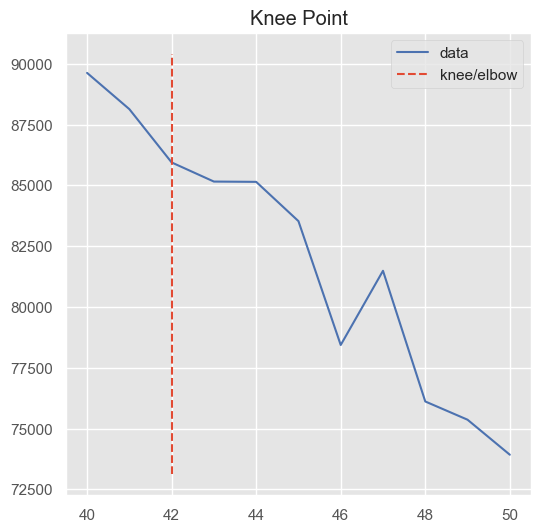

In [23]:
#Elbow method
kmeans_kwargs = {"init": "random",  "n_init": 100, "max_iter": 300, "random_state":random_seed}

sse = []
for k in range(40, 51):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X1)
    sse.append(kmeans.inertia_)
    
# plt.plot(range(1, 51), sse, color="#00cfcc" )
# plt.xticks(range(1, 51))
# plt.xlabel("Number of Clusters")
# plt.ylabel("SSE")
# plt.show()   

# identify the elbow point automatically
kl = KneeLocator(range(40, 51), sse, curve="convex", direction="decreasing")
print("======================================================================================================")
print("\nElbow point :",kl.elbow)
kl.plot_knee()

#Choose K

kmeans = KMeans(init="random", n_clusters=42, n_init=100, max_iter=300)
#kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 500, "random_state": random_state}
kmeans.fit(X1)
y_kmeans = kmeans.predict(X1)
df.loc[:,"y_kmeans"]=y_kmeans

# The lowest SSE value
print("\nThe lowest SSE value:",round(kmeans.inertia_,2))

# Calculate silhouette_score to make comparissons
score_HC = silhouette_score(X1, df.y_kmeans, metric='euclidean')
print("\nSilhouette score:", round(score_HC,2))
print("\nCalinski Harabasz:", calinski_harabasz_score(X1,df.y_kmeans))
print("\nDavies Bouldin:", davies_bouldin_score(X1,df.y_kmeans))

print("======================================================================================================")

# Percentage by cluster
group_and_size(df['y_kmeans'],df['Formulebible'])

### K-means ++

/Users/gxxdx/opt/anaconda3/lib/python3.9/site-packages/kneed/knee_locator.py:311: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")
/Users/gxxdx/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1172: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/Users/gxxdx/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1173: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])



Elbow point : None

The lowest SSE value: 73974.13

Silhouette score: 0.48

Calinski Harabasz: 241.2207731276659

Davies Bouldin: 0.8122173646441196


,Cluster,Size
0,30,47
1,2,43
2,1,32
3,4,31
4,13,26
5,16,25
6,25,19
7,3,18
8,31,17
9,23,17


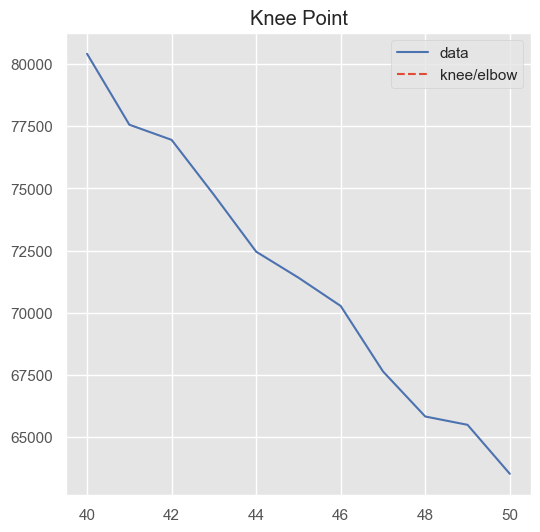

In [24]:
kmeans_kwargs = { "init": "k-means++",  "n_init": 100, "max_iter": 300, "random_state":random_seed}

sse = []
for k in range(40, 51):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X1)
    sse.append(kmeans.inertia_)
    
# plt.plot(range(1, 51), sse, color="#00cfcc")
# plt.xticks(range(1, 51))
# plt.xlabel("Number of Clusters")
# plt.ylabel("SSE")
# plt.show()   

# identify the elbow point automatically
kl = KneeLocator(range(40, 51), sse, curve="convex", direction="decreasing")
print("======================================================================================================")
print("\nElbow point :",kl.elbow)
kl.plot_knee()

#Choose K

kmeans = KMeans(init="k-means++", n_clusters=43, n_init=100, max_iter=300)
kmeans.fit(X1)
y_kmeans = kmeans.predict(X1)
df.loc[:,"y_kmeans++"]=y_kmeans


# The lowest SSE value
print("\nThe lowest SSE value:",round(kmeans.inertia_,2))
# Calculate silhouette_score to make comparissons
score_HC = silhouette_score(X1,df['y_kmeans++'], metric='euclidean')
print("\nSilhouette score:", round(score_HC,2))
print("\nCalinski Harabasz:", calinski_harabasz_score(X1,df['y_kmeans++']))
print("\nDavies Bouldin:", davies_bouldin_score(X1,df['y_kmeans++']))

print("======================================================================================================")


# Percentage by cluster
group_and_size(df['y_kmeans++'],df['Formulebible'])

## Hierarchical Tree Clustering - HCT

### HTC (Ward)

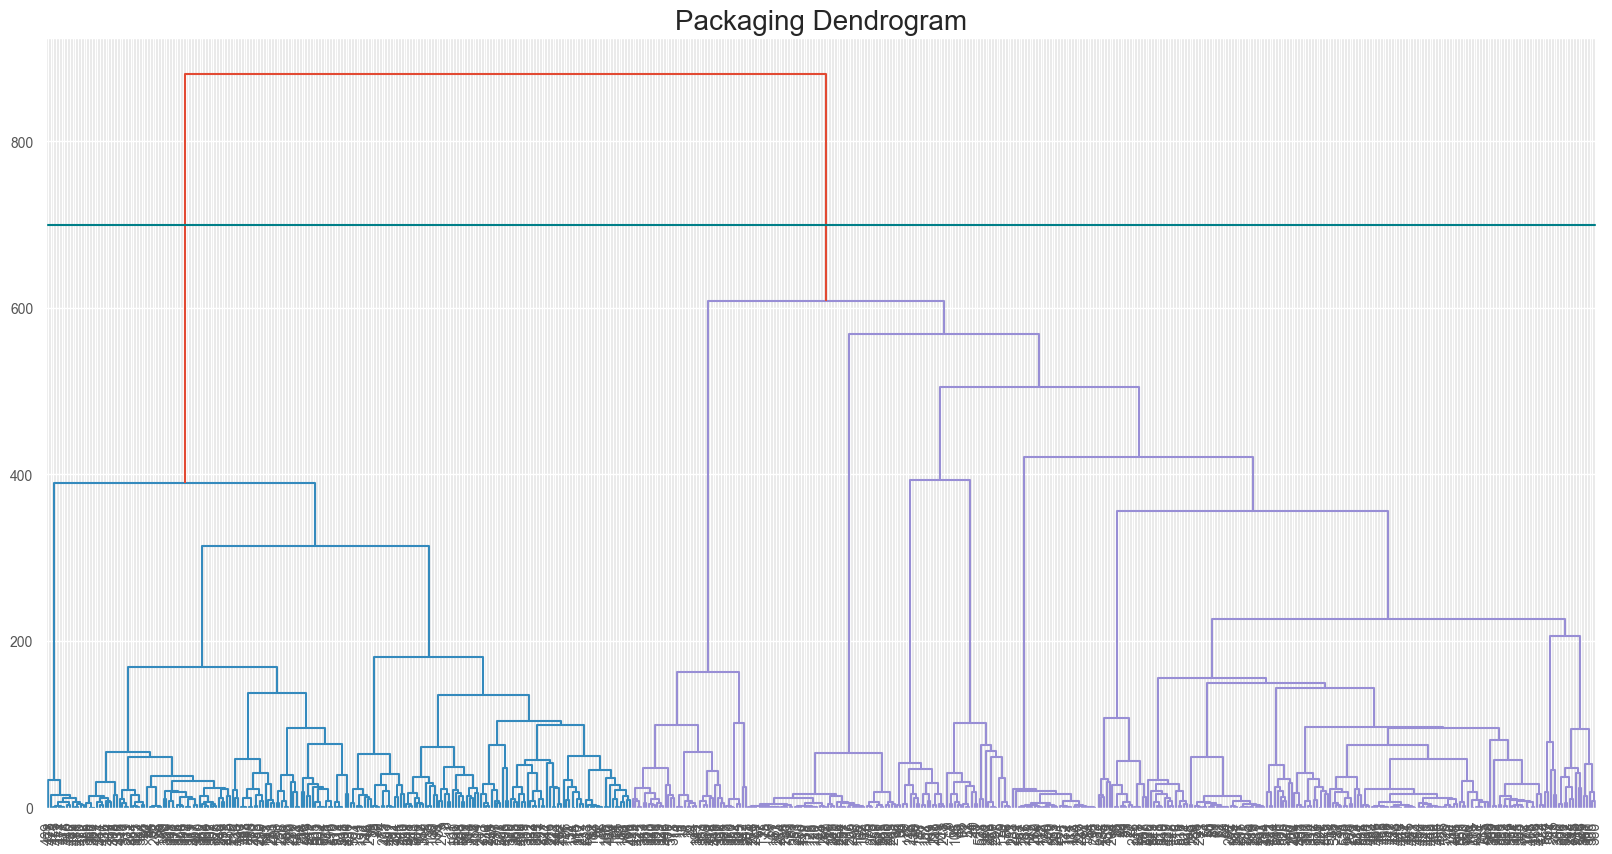


Silhouette score: 0.49

Calinski Harabasz: 240.44376383089468

Davies Bouldin: 0.8023026830953403


,Cluster,Size
0,40,43
1,46,35
2,49,31
3,19,31
4,28,26
5,2,18
6,17,17
7,27,17
8,11,16
9,8,15


In [25]:
plt.figure(figsize=(20, 10))
plt.title("Packaging Dendrogram",fontsize=20)

# Dendogram for different method and metrics
selected_data = X1
clusters = shc.linkage(selected_data, 
            method='ward', 
            metric="euclidean")

shc.dendrogram(Z=clusters)
plt.tick_params(labelsize=10)
plt.axhline(y = 700, color = "#007f88", linestyle = 'solid')
plt.show()

cluster = AgglomerativeClustering(n_clusters=50, affinity='euclidean', linkage='ward')
cluster.fit(X1)
cluster.labels_
cluster_num = cluster.labels_
df.loc[:,"y_hc_ward"]=cluster_num
df.to_excel('df_kmeans.xlsx', index=False)

# Calculate silhouette_score to make comparissons
score_HC = silhouette_score(X1, df.y_hc_ward, metric='euclidean')
print("======================================================================================================")
print("\nSilhouette score:", round(score_HC,2))
print("\nCalinski Harabasz:", calinski_harabasz_score(X1, df.y_hc_ward))
print("\nDavies Bouldin:", davies_bouldin_score(X1, df.y_hc_ward))

print("======================================================================================================")

group_and_size(df.y_hc_ward,df['Formulebible'])

### HTC (Complete)

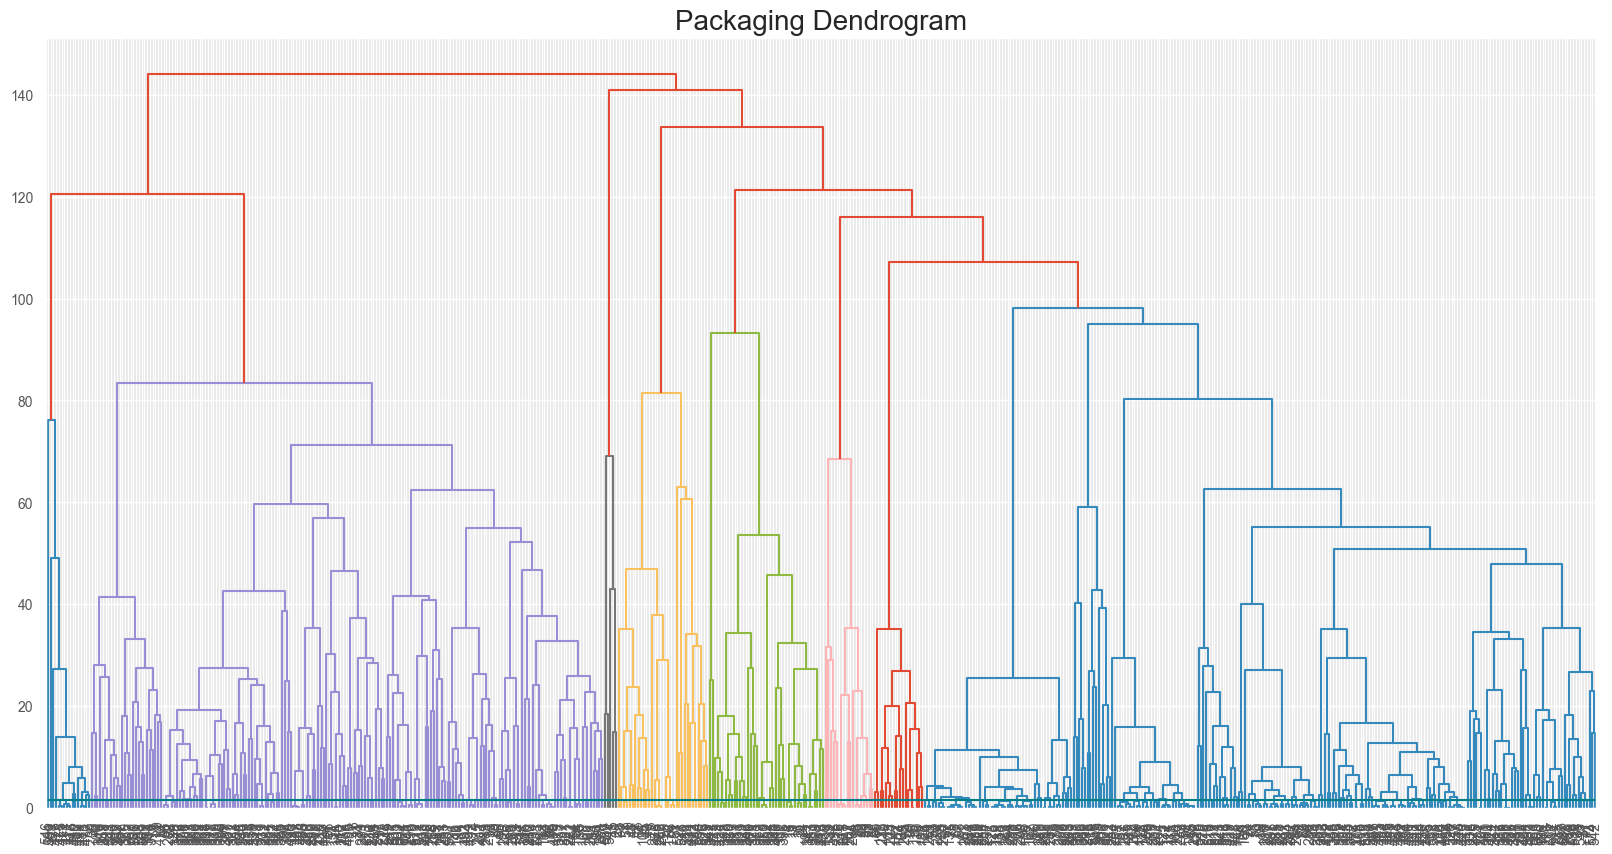


Silhouette score: 0.47

Calinski Harabasz: 211.98631859023018

Davies Bouldin: 0.7764636930756282


,Cluster,Size
0,6,54
1,17,54
2,18,43
3,27,31
4,40,27
5,31,26
6,15,24
7,5,23
8,2,19
9,23,18


In [26]:
plt.figure(figsize=(20, 10))
plt.title("Packaging Dendrogram",fontsize=20)

# Dendogram for different method and metrics
selected_data = X1
clusters = shc.linkage(selected_data, 
            method='complete', 
            metric="euclidean")

shc.dendrogram(Z=clusters)
plt.tick_params(labelsize=10)
plt.axhline(y = 1.4, color = "#007f88", linestyle = 'solid')
plt.show()

cluster = AgglomerativeClustering(n_clusters=48, affinity='euclidean', linkage='complete')
cluster.fit(X1)
cluster.labels_
cluster_num = cluster.labels_
df.loc[:,"y_hc_com"]=cluster_num
df.to_excel('df_kmeans.xlsx', index=False)

# Calculate silhouette_score to make comparissons
score_HC = silhouette_score(X1, df.y_hc_com, metric='euclidean')
print("======================================================================================================")
print("\nSilhouette score:", round(score_HC,2))
print("\nCalinski Harabasz:", calinski_harabasz_score(X1, df.y_hc_com))
print("\nDavies Bouldin:", davies_bouldin_score(X1, df.y_hc_com))
print("======================================================================================================")

group_and_size(df.y_hc_com,df['Formulebible'])

# HTC (Single)

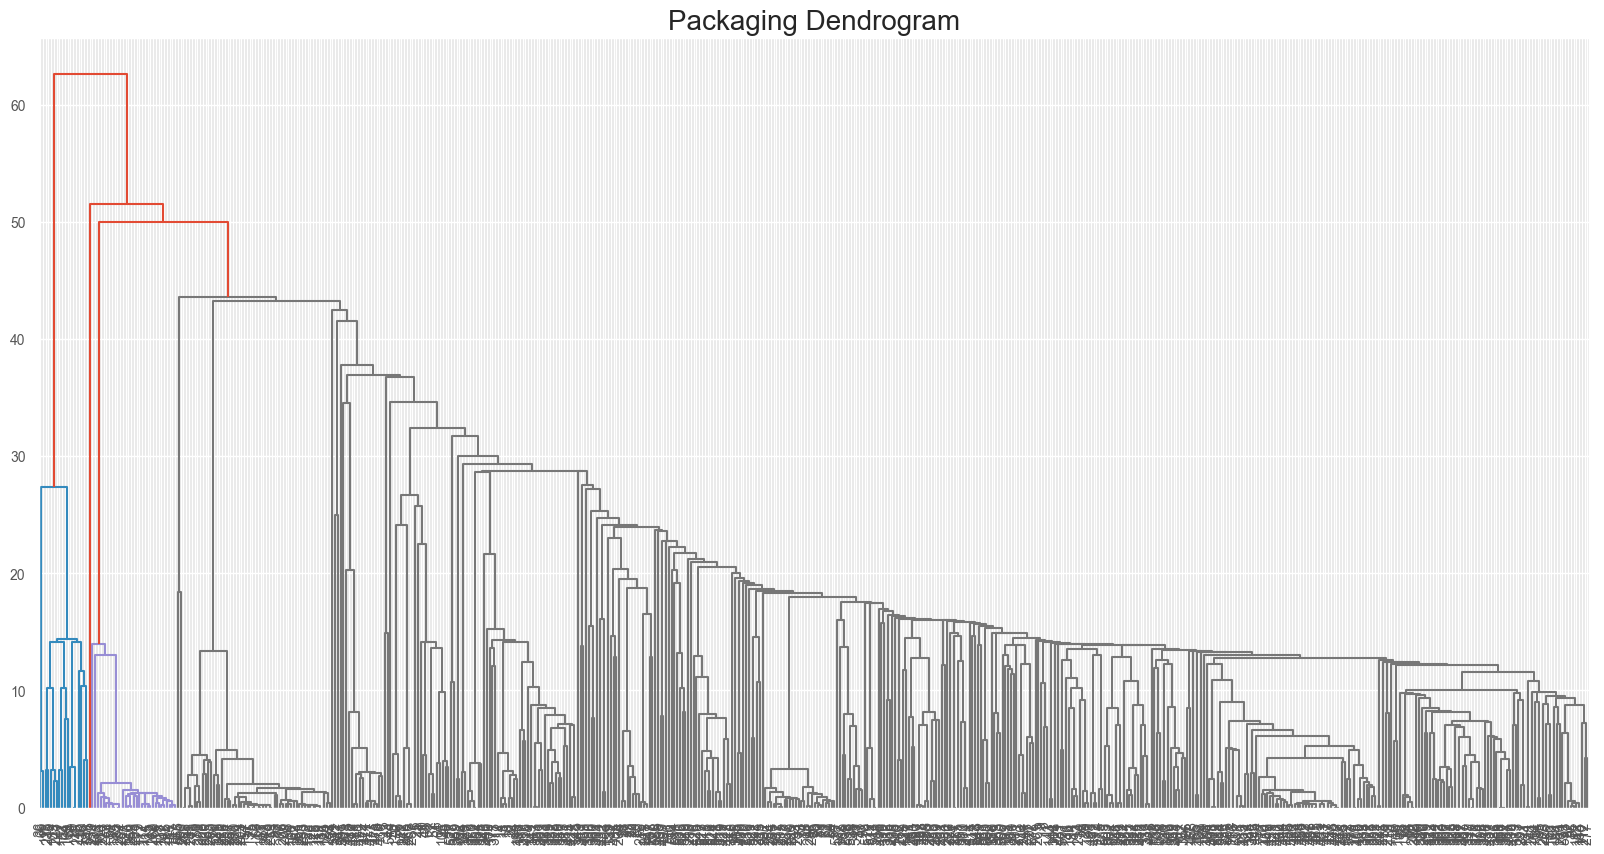


Silhouette score: 0.11

Calinski Harabasz: 31.00191605597875

Davies Bouldin: 0.6453018681419427


,Cluster,Size
0,0,327
1,5,54
2,19,33
3,15,31
4,1,16
5,7,16
6,2,14
7,8,11
8,3,6
9,17,6


In [27]:
plt.figure(figsize=(20, 10))
plt.title("Packaging Dendrogram",fontsize=20)

# Dendogram for different method and metrics
selected_data = X1
clusters = shc.linkage(selected_data, 
            method='single', 
            metric="euclidean")

shc.dendrogram(Z=clusters)
plt.tick_params(labelsize=10)
#plt.axhline(y = 1.5, color = "#007f88", linestyle = 'solid')
plt.show()

cluster = AgglomerativeClustering(n_clusters=40, affinity='euclidean', linkage='single')
cluster.fit(X1)
cluster.labels_
cluster_num = cluster.labels_
df.loc[:,"y_hc_sgl"]=cluster_num
df.to_excel('df_kmeans.xlsx', index=False)

# Calculate silhouette_score to make comparissons
score_HC = silhouette_score(X1, df.y_hc_sgl, metric='euclidean')
print("======================================================================================================")
print("\nSilhouette score:", round(score_HC,2))
print("\nCalinski Harabasz:", calinski_harabasz_score(X1, df.y_hc_sgl))
print("\nDavies Bouldin:", davies_bouldin_score(X1, df.y_hc_sgl))
print("======================================================================================================")

group_and_size(df.y_hc_sgl,df['Formulebible'])

### HTC (Average) 

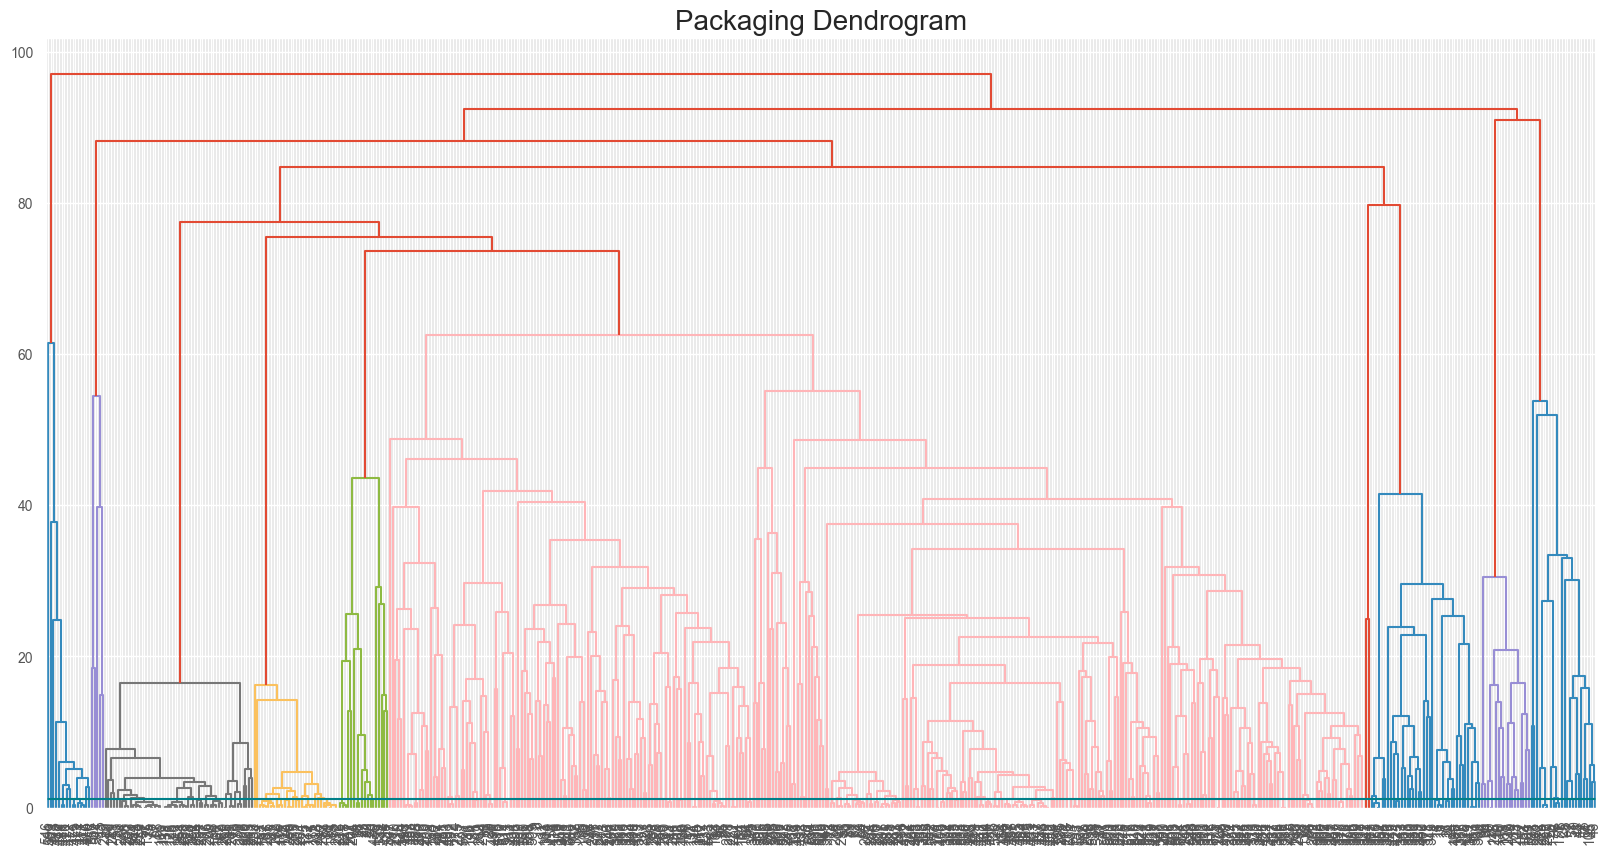


Silhouette score: 0.45

Calinski Harabasz: 164.21465950739423

Davies Bouldin: 0.6263628457368355


,Cluster,Size
0,16,105
1,1,72
2,34,54
3,20,51
4,8,34
5,37,31
6,10,25
7,7,24
8,3,18
9,22,15


In [28]:
plt.figure(figsize=(20, 10))
plt.title("Packaging Dendrogram",fontsize=20)

# Dendogram for different method and metrics
selected_data = X1
clusters = shc.linkage(selected_data, 
            method='average', 
            metric="euclidean")

shc.dendrogram(Z=clusters)
plt.tick_params(labelsize=10)
plt.axhline(y = 1.17, color = "#007f88", linestyle = 'solid')
plt.show()

cluster = AgglomerativeClustering(n_clusters=40, affinity='euclidean', linkage='average')
cluster.fit(X1)
cluster.labels_
cluster_num = cluster.labels_
df.loc[:,"y_hc_avg"]=cluster_num

# Calculate silhouette_score to make comparissons
score_HC = silhouette_score(X1, df.y_hc_avg, metric='euclidean')
print("======================================================================================================")
print("\nSilhouette score:", round(score_HC,2))
print("\nCalinski Harabasz:", calinski_harabasz_score(X1, df.y_hc_avg))
print("\nDavies Bouldin:", davies_bouldin_score(X1, df.y_hc_avg))
print("======================================================================================================")

group_and_size(df.y_hc_avg,df['Formulebible'])

# Gaussian Matrix - Expectation–Maximization (EM)

In [29]:
EM = GaussianMixture(n_components =50, random_state =random_seed )
EM.fit(X1)
cluster = EM.predict(X1)
df.loc[:,"y_EM"]=cluster

# Calculate silhouette_score to make comparissons
score_EM = silhouette_score(X1, df.y_EM, metric='euclidean')
print("======================================================================================================")
print("\nSilhouette score:", round(score_EM,2))
print("\nCalinski Harabasz:", calinski_harabasz_score(X1, df.y_EM))
print("\nDavies Bouldin:", davies_bouldin_score(X1, df.y_EM))
print("======================================================================================================")

group_and_size(df.y_EM,df['Formulebible'])


Silhouette score: 0.32

Calinski Harabasz: 106.77737638216169

Davies Bouldin: 1.0859188343899522


,Cluster,Size
0,45,61
1,14,48
2,17,43
3,11,37
4,31,30
5,0,26
6,12,19
7,8,18
8,16,16
9,2,15


# Efficiency evaluation

## Distance measure

In [30]:
#plant sorting

dfKuf = df[df["Plant"]=="Kufstein"]
dfWarb = df[df["Plant"]=="Halle/Warburg"]
dfFirm = df[df["Plant"]=="Firminy/montfaucon"]



#Calculates the sum of Eucleidian distances of each product from one plant from the average centroid
#Helps to calculate the efficiency of products allocation to plants
def Spread (df) :
    dfcut = df.iloc[:,3:51]
    avgcol = np.zeros(48)
    eucdist = np.zeros(len(dfcut))
    i=0
    for column in dfcut:
        avgcol[i] = dfcut[column].mean()
        i+= 1

    for k in range(len(dfcut)):
        dist = 0
        j=0
        for column in dfcut:
            dist = dist + (dfcut.iloc[k,j] - avgcol[j])**2
            j += 1
        eucdist[k] = math.sqrt(dist)
    sumdist = eucdist.mean()
    return(sumdist)
print("Using the curent distribution, the average distance of a product from a centroid is: ")
print(str(round(Spread(dfKuf),2))+" for Kufstein")
print(str(round(Spread(dfWarb),2))+" for Halle/Warburg")
print(str(round(Spread(dfFirm),2))+" for Firminy/montfaucon")

Using the curent distribution, the average distance of a product from a centroid is: 
71.64 for Kufstein
58.6 for Halle/Warburg
67.86 for Firminy/montfaucon


## Measuring the change

In [31]:

#EVALUATION 2
# produsct association to plants

# dfRes = pd.read_csv("dfRes.csv", encoding=result["encoding"], header=0, delimiter=';')
# dfRes.to_csv('new_file.csv', index=False, encoding='utf-8')

# dfRes = pd.read_csv('new_file.csv', header=0, delimiter=',', decimal=',')
# print(dfRes.columns)
# dfRes.iloc[:,0]

#associate one cluster to one plant based on its occurence
def PlantAss(df, cluster, method):
    dfClust = df[df[method] == cluster]
    grouped = dfClust['Plant'].value_counts().to_frame().reset_index().rename(columns={'index':'values', 'Plant':'count'})
    maxPlant = grouped[grouped['count'] == grouped['count'].max()]
    plant = maxPlant['values'][0]
    return(plant)

PlantAss(df, 8, "y_kmeans")

#counts number of product moved from one plant to another
def PlantMove(df, cluster, method):
    dfClust = df[df[method] == cluster]
    grouped = dfClust['Plant'].value_counts().to_frame().reset_index().rename(columns={'index':'values', 'Plant':'count'})
    minPlants = grouped[grouped['count'] != grouped['count'].max()]
    summove = minPlants['count'].sum()
    return(summove)

PlantMove(df, 8, "y_kmeans")

#counts number of product moved from one plant to another
def PlantMovePerc(df, cluster, method):
    dfClust = df[df[method] == cluster]
    grouped = dfClust['Plant'].value_counts().to_frame().reset_index().rename(columns={'index':'values', 'Plant':'count'})
    summ = grouped['count'].sum()
    minPlants = grouped[grouped['count'] != grouped['count'].max()]
    summove = minPlants['count'].sum()
    percmove = summove/summ
    return((percmove*100).round(2))

PlantMovePerc(df, 8, "y_kmeans")


#counts number of product moved from one plant to another
def PlantProducts(df, cluster, method):
    dfClust = df[df[method] == cluster]
    grouped = dfClust['Plant'].value_counts().to_frame().reset_index().rename(columns={'index':'values', 'Plant':'count'})
    sumcount = grouped['count'].sum()
    return(sumcount)

PlantProducts(df, 8, "y_kmeans")

#creates a df of clusters and plants corresponding to them
def PlantAssFinal(df, method):
    maxClus = df[method].max()
    minClus = df[method].min()
    plantClus = ["" for x in range(maxClus+1)]
    moveClus = np.zeros(maxClus+1)
    movePercClus = np.zeros(maxClus+1)
    productsClus = np.zeros(maxClus+1)
    kuf = []
    war = []
    fir = []
    
    for i in range(minClus, maxClus+1):
        plantClus[i] = PlantAss(df,i, method)
        moveClus[i] = PlantMove(df,i, method)
        movePercClus[i] = PlantMovePerc(df,i, method)
        productsClus[i] = PlantProducts(df,i, method)
        if (plantClus[i] == "Kufstein"):
            kuf.append(i)
        if (plantClus[i] == "Halle/Warburg"):
            war.append(i)
        if (plantClus[i] == "Firminy/montfaucon"):
            fir.append(i)
    data = {'cluster': range(maxClus+1), 'plant': plantClus, '# products': productsClus, '# products moved': moveClus, '% products moved': movePercClus}
    dtf = pd.DataFrame(data=data) 
    totMove = dtf['# products moved'].sum()
    totPercMove = (dtf['# products moved'].sum() / dtf['# products'].sum())*100
    
    dfKuf2 = df[df[method].isin(kuf)]
    dfWar2 = df[df[method].isin(war)]
    dfFir2 = df[df[method].isin(fir)]
    print("Using the new distribution, the average distance of a product from a centroid is: ")
    print(str(round(Spread(dfKuf2),2))+" for Kufstein")
    print(str(round(Spread(dfWar2),2))+" for Halle/Warburg")
    print(str(round(Spread(dfFir2),2))+" for Firminy/montfaucon")
    
    print('We moved the production of ' + str(totMove) + ' products to another plant. This corresponds to ' + str(round(totPercMove,2)) + '% of the whole production.')
    print(dtf)
    name = method+"_plant"
    
    plants  =[]
    for i in range(0, len(df)):
        if df[method][i] in kuf:
            plants.append("Kufstein")
        if df[method][i] in war:
            plants.append("Halle/Warburg")
        if df[method][i] in fir:
            plants.append("Firminy/montfaucon")
    
    return(plants)

In [32]:
PlantAssFinal(df, "y_hc_ward")

Using the new distribution, the average distance of a product from a centroid is: 
72.73 for Kufstein
59.67 for Halle/Warburg
66.44 for Firminy/montfaucon
We moved the production of 84.0 products to another plant. This corresponds to 14.95% of the whole production.
    cluster               plant  # products  # products moved  \
0         0            Kufstein        13.0               0.0   
1         1            Kufstein         6.0               2.0   
2         2            Kufstein        18.0               0.0   
3         3  Firminy/montfaucon        10.0               2.0   
4         4       Halle/Warburg         5.0               0.0   
5         5       Halle/Warburg        13.0               0.0   
6         6  Firminy/montfaucon         3.0               0.0   
7         7       Halle/Warburg        10.0               1.0   
8         8            Kufstein        15.0               6.0   
9         9  Firminy/montfaucon         6.0               0.0   
10       10        

['Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Firminy/montfaucon',
 'Kufstein',
 'Firminy/montfaucon',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Firminy/montfaucon',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Halle/Warburg',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Halle/Warburg',
 'Kufstein',
 'Kufstein',
 'Firminy/montfaucon',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 'Kufstein',
 

In [33]:
df["ward_plant"] = PlantAssFinal(df, "y_hc_ward")
df

Using the new distribution, the average distance of a product from a centroid is: 
72.73 for Kufstein
59.67 for Halle/Warburg
66.44 for Firminy/montfaucon
We moved the production of 84.0 products to another plant. This corresponds to 14.95% of the whole production.
    cluster               plant  # products  # products moved  \
0         0            Kufstein        13.0               0.0   
1         1            Kufstein         6.0               2.0   
2         2            Kufstein        18.0               0.0   
3         3  Firminy/montfaucon        10.0               2.0   
4         4       Halle/Warburg         5.0               0.0   
5         5       Halle/Warburg        13.0               0.0   
6         6  Firminy/montfaucon         3.0               0.0   
7         7       Halle/Warburg        10.0               1.0   
8         8            Kufstein        15.0               6.0   
9         9  Firminy/montfaucon         6.0               0.0   
10       10        

,Étiquettesdelignes,Formulebible,Plant,couche1,couche2,couche3,AD,EVA045,EVA14,EVA18,EVA28,HD,LD,LLD,LLD_C4,LLD_C6,LLD_C8,MB,MD,mLLD_C4,mLLD_C6,mLLD_C8,mPE_C8,mVLLD_C8,Reg,EVA1,EVA2,y_kmeans,y_kmeans++,y_hc_ward,y_hc_com,y_hc_sgl,y_hc_avg,y_EM,ward_plant
0,100098,100098,Kufstein,10.0,70.0,20.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,75.948,11.12,12.932,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,30,9,22,3,8,4,4,Kufstein
1,101087,101087,Kufstein,20.0,60.0,20.0,0.00,0.0,0.0,0.0,0.0,0.0,58.60,40.000,0.00,0.000,0.0,1.40,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,3,17,41,2,0,10,12,Kufstein
2,101088,101088,Kufstein,20.0,70.0,10.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,75.948,11.12,12.932,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,30,9,22,3,8,4,4,Kufstein
3,101189,101189,Kufstein,30.0,40.0,30.0,0.00,0.0,0.0,0.0,0.0,0.0,79.04,0.000,19.76,0.000,0.0,1.20,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,27,19,8,0,0,7,45,Kufstein
4,101581,101581,Kufstein,20.0,60.0,20.0,0.00,0.0,0.0,0.0,0.0,0.0,79.40,20.000,0.00,0.000,0.0,0.60,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,3,32,26,2,0,10,12,Kufstein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,ZF0750H1AC,ZF0750H1AC,Firminy/montfaucon,20.0,60.0,20.0,5.60,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.00,0.000,0.0,0.00,85.4,0.00,0.0,0.0,0.0,0.0,9.0,0.0,0.00,6,14,31,34,4,13,27,Firminy/montfaucon
558,ZF0752A2,ZF0752A2,Firminy/montfaucon,20.0,60.0,20.0,2.80,0.0,0.0,0.0,0.0,41.4,0.00,16.200,0.00,0.000,0.0,0.00,0.0,39.60,0.0,0.0,0.0,0.0,0.0,0.0,0.00,2,12,14,38,30,0,46,Firminy/montfaucon
559,ZF0770A1,ZF0770A1,Firminy/montfaucon,8.0,72.0,20.0,1.08,0.0,0.0,0.0,0.0,0.0,0.00,0.000,13.00,0.000,0.0,0.00,0.0,78.00,0.0,0.0,0.0,0.0,0.0,0.0,7.92,26,8,21,5,0,16,11,Kufstein
560,ZF0770A1AA,ZF0770A1AA,Firminy/montfaucon,8.0,72.0,20.0,3.12,0.0,0.0,0.0,0.0,0.0,0.00,0.000,12.40,0.000,0.0,0.00,0.0,76.56,0.0,0.0,0.0,0.0,0.0,0.0,7.92,26,8,21,5,0,16,11,Kufstein


In [34]:
df.to_excel("output_clustering.xlsx") 

In [35]:
# assuming 'Plant', 'y-hc-ward', and 'Formulebible' are columns in your DataFrame called df
pivot_df = pd.pivot_table(df, values='Formulebible', index=['y_hc_ward', 'ward_plant'], aggfunc='count')
pivot_df

,,Formulebible
y_hc_ward,ward_plant,
0,Kufstein,13
1,Kufstein,6
2,Kufstein,18
3,Firminy/montfaucon,10
4,Halle/Warburg,5
5,Halle/Warburg,13
6,Firminy/montfaucon,3
7,Halle/Warburg,10
8,Kufstein,15


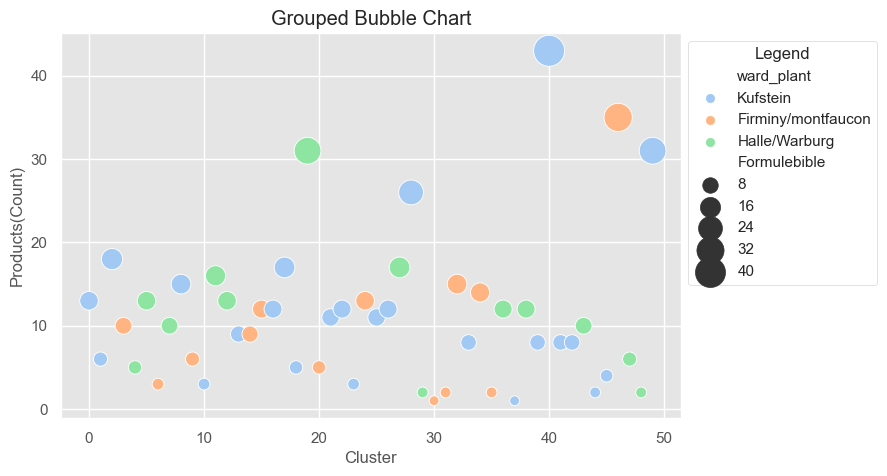

In [36]:
# assuming 'Plant', 'y-hc-ward', and 'Formulebible' are columns in your DataFrame called df
pivot_df = pd.pivot_table(df, values='Formulebible', index=['y_hc_ward', 'ward_plant'], aggfunc='count').reset_index()

sns.set_palette('pastel') # set a different color palette
ax = sns.scatterplot(x='y_hc_ward', y='Formulebible', size='Formulebible', hue='ward_plant', data=pivot_df, sizes=(50, 500))
ax.set_xlabel('Cluster') # change the X-axis label
ax.set_ylabel('Products(Count)') # change the Y-axis label
plt.legend(title='Legend', loc='upper left', bbox_to_anchor=(1, 1), facecolor ="white")
plt.title('Grouped Bubble Chart')
plt.savefig('grouped_bubble_chart.png', transparent=True, dpi=300, bbox_inches='tight') # save the plot as a PNG file
plt.show()